# Produce GAF Files for CNN

In [85]:
import numpy as np
import pandas as pd

from series2gaf import GenerateGAF, PlotHeatmap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Study on Producing GAF

In [86]:
data_path = "nasdaq-d.csv"
load_bars = 15 # trial only

df_full = (pd.read_csv(data_path, parse_dates=True)
  .drop(['Adj Close', 'Volume'], axis=1)
  .set_index('Date')
 )
df["Upper"] = df.apply(lambda x: x.High-x.Close if x.Close >= x.Open else x.High-x.Open, axis=1)
df["Lower"] = df.apply(lambda x: x.Open-x.Low if x.Open <= x.Close else x.Close-x.Low, axis=1)
df["RealBody"] = df.apply(lambda x: abs(x.Close-x.Open), axis=1)

df = df[-load_bars:]
print(df.shape)
df.head()

(15, 7)


,Open,High,Low,Close,Upper,Lower,RealBody
Date,,,,,,,
2022-03-04,13455.230469,13486.709961,13224.980469,13313.440430,31.479492,88.459961,141.790039
2022-03-07,13328.360352,13353.280273,12828.019531,12830.959961,24.919921,2.940430,497.400391
2022-03-08,12800.040039,13159.440430,12670.080078,12795.549805,359.400391,125.469727,4.490234
2022-03-09,13113.700195,13301.160156,13039.790039,13255.549805,45.610351,73.910156,141.849610
2022-03-10,13098.349609,13163.500000,12946.280273,13129.959961,33.540039,152.069336,31.610352


In [87]:
n = df.shape[0]
moving_window_size = 10
rolling_length = 1
1 + int(np.floor((n - moving_window_size)/rolling_length))

6

In [88]:
start_date = df.Close.index[0]
window_size = 10
col = "Open"
f"{start_date}-w{window_size:03}-{col}.pkl"

'2022-03-04-w010-Open.pkl'

## `generate_gaf` function

In [89]:
# Main function
from tqdm import trange
import os 

def generate_gaf(all_ts_series, window_size, rolling_length, output_dir, 
                normalize_window_scaling=1.0, method='summation', scale='[0,1]'):
    """ 
    Parameters
        all_ts_series : series, the entire timeseries source
        window_size : GAF window size
        rolling_length : number of steps?
        fname: filename to save to        
    """    
    os.makedirs(output_dir, exist_ok=True)     
    
    all_ts = all_ts_series.values
    
    # Get the length of the time series
    n = len(all_ts) 
    
    # We want to avoid overscaling the micro, so the moving window_size is a multiple of the original normalize_window_scaling
    moving_window_size = int(window_size * normalize_window_scaling)
    
    # Slice and dice the data into groups according to our scrolling size
    #. number of gaf entries we will make
    n_rolling_data = 1 + int(np.floor((n - moving_window_size)/rolling_length))
    
    # The final GAF
    #. gramian_field = []
    
    # Record the price, used to draw the graph
    #Prices = []

    # Start advancing from the first profile
    for i_rolling_data in trange(n_rolling_data, desc="Generating...", ascii=True):

         # Start position
        start_flag = i_rolling_data*rolling_length
        
         # The data of the whole pane is first taken from the input time series
        full_window_data =  list(all_ts[start_flag : start_flag+moving_window_size])
    
        #. if debugging/tracing 
        #. print(f"py range: {start_flag}, {start_flag+moving_window_size}")

        # Record the information of the window pane and use it to draw a picture
        #Prices.append(full_window_data[-int(window_size*(normalize_window_scaling-1)):])
        
        # Because we have to do cos/sin operation, so first normalize the time series
        rescaled_ts = np.zeros((moving_window_size, moving_window_size), float)
        min_ts, max_ts = np.min(full_window_data), np.max(full_window_data)
        if scale == '[0,1]':
            diff = max_ts - min_ts
            if diff != 0:
                rescaled_ts = (full_window_data - min_ts) / diff
        if scale == '[-1,1]':
            diff = max_ts - min_ts
            if diff != 0:
                rescaled_ts = (2 * full_window_data - diff) / diff

        # leave the original window_size length information
        rescaled_ts = rescaled_ts[-int(window_size*(normalize_window_scaling-1)):]
        
        # Calculate the Gramian Angular Matrix
        this_gam = np.zeros((window_size, window_size), float)
        sin_ts = np.sqrt(np.clip(1 - rescaled_ts**2, 0, 1))
        if method == 'summation':
            # cos(x1+x2) = cos(x1)cos(x2) - sin(x1)sin(x2)
            this_gam = np.outer(rescaled_ts, rescaled_ts) - np.outer(sin_ts, sin_ts)
        if method == 'difference':
            # sin(x1-x2) = sin(x1)cos(x2) - cos(x1)sin(x2)
            this_gam = np.outer(sin_ts, rescaled_ts) - np.outer(rescaled_ts, sin_ts)
                        
        #. gramian_field.append(this_gam)

        # save individual windows
        start_date =  all_ts_series.index[start_flag]  
        fname = f"{start_date}-w{window_size:03}-{col}.pkl"
        np.array(this_gam).dump(f'{output_dir}/{fname}')
            
        # Clear the memory footprint
        del this_gam
    
    #. # Output the gramian corner field
    #. np.array(gramian_field).dump('%s_gaf.pkl'%fname)

    # 1Clear memory footprint
    #. del gramian_field

### Generate sample GAF

In [90]:
col = "Close"
output_dir = "nasdaq-daily-1K"
generate_gaf(
    all_ts_series = df[col],
    window_size = 10,
    rolling_length = 1,
    output_dir = output_dir)

Generating...: 100%|##########| 6/6 [00:00<00:00, 597.93it/s]


### Load a sample GAF

In [92]:
sample =  np.load(f"{output_dir}/2022-03-04-w010-Close.pkl", allow_pickle=True)
sample.shape, sample

((10, 10),
 array([[ 0.00378837, -0.51367078, -0.54351385, -0.07264812, -0.2219516 ,
         -0.50261835, -0.70576612, -0.40783941,  0.19007404,  0.70844491],
        [-0.51367078, -0.88322895, -0.89916763, -0.57774094, -0.69402274,
         -0.87713852, -0.97036822, -0.8210983 , -0.34478386,  0.24163097],
        [-0.54351385, -0.89916763, -0.91399486, -0.60607618, -0.71890207,
         -0.89347803, -0.97826246, -0.8406555 , -0.37756794,  0.20737061],
        [-0.07264812, -0.57774094, -0.60607618, -0.14865966, -0.29582217,
         -0.56721921, -0.75784552, -0.47642758,  0.11448543,  0.65243404],
        [-0.2219516 , -0.69402274, -0.71890207, -0.29582217, -0.43624325,
         -0.68472679, -0.84742057, -0.60334615, -0.03635834,  0.5309222 ],
        [-0.50261835, -0.87713852, -0.89347803, -0.56721921, -0.68472679,
         -0.87090364, -0.96718758, -0.81370606, -0.33270982,  0.25406334],
        [-0.70576612, -0.97036822, -0.97826246, -0.75784552, -0.84742057,
         -0.96718758,

### Show sample as Image

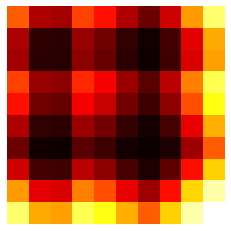

In [93]:
from matplotlib import pyplot as plt
plt.imshow(sample, cmap='hot', interpolation='nearest')
plt.axis('off');

### Check if output is the same when using the package

In [94]:
GenerateGAF(all_ts = df.Close,
            window_size = 10,
            rolling_length = 1,
            fname = "nasdaq15-w010-Close")

Generating...: 100%|##########| 6/6 [00:00<00:00, 3524.13it/s]

Saved nasdaq15-w010-Close_gaf.pkl


In [95]:
nasdaq15_gaf = np.load("nasdaq15-w010-Close_gaf.pkl", allow_pickle=True)
PlotHeatmap(nasdaq15_gaf, save_dir='temp')

Output Heatmaps...: 100%|##########| 6/6 [00:00<00:00, 14.07it/s]


<Figure size 432x288 with 0 Axes>

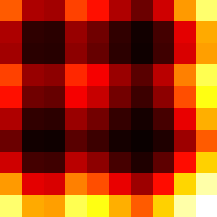

In [96]:
from IPython import display
display.Image("temp/0.png")

# Create GAF pkl files for 1K data of nasdaq

In [97]:
data_path = "nasdaq-d.csv"
load_bars = 1000

df_full = (pd.read_csv(data_path, parse_dates=True)
  .drop(['Adj Close', 'Volume'], axis=1)
  .set_index('Date')
 )
df_full["Upper"] = df.apply(lambda x: x.High-x.Close if x.Close >= x.Open else x.High-x.Open, axis=1)
df_full["Lower"] = df.apply(lambda x: x.Open-x.Low if x.Open <= x.Close else x.Close-x.Low, axis=1)
df_full["RealBody"] = df.apply(lambda x: abs(x.Close-x.Open), axis=1)

df1K = df_full[-load_bars:]
print(df1K.shape)
df1K.head()

(1000, 7)


,Open,High,Low,Close,Upper,Lower,RealBody
Date,,,,,,,
2018-04-06,6999.569824,7066.640137,6877.759766,6915.109863,NaN,NaN,NaN
2018-04-09,6971.450195,7074.950195,6944.959961,6950.339844,NaN,NaN,NaN
2018-04-10,7060.990234,7117.979980,7014.879883,7094.299805,NaN,NaN,NaN
2018-04-11,7055.000000,7128.540039,7055.000000,7069.029785,NaN,NaN,NaN
2018-04-12,7112.020020,7166.000000,7105.089844,7140.250000,NaN,NaN,NaN


In [98]:
output_dir = "nasdaq-daily-1K"
cols = ['Open', 'High', 'Low', 'Close', 'Upper', 'Lower', 'RealBody']
for col in cols:
    generate_gaf(
        all_ts_series = df1K[col],
        window_size = 10,
        rolling_length = 1,
        output_dir = output_dir)

Generating...: 100%|##########| 991/991 [00:01<00:00, 942.36it/s] 


#### Count the number of files in outputdir

In [99]:
!ls  nasdaq-daily-1K | wc -l

6937


In [145]:
# number of windows
6937 /len(cols)

991.0

## `get_gaf` function

In [139]:
gaf = np.zeros( (window_size**2, 4)) 
gaf.shape

(100, 4)

In [140]:
gaf.reshape(-1).shape

(400,)

In [141]:
idx = 1
start_date = df1K.index[idx]
start_date

'2018-04-09'

In [142]:
data_cols = ['Open', 'High', 'Low', 'Close']
output_dir = "nasdaq-daily-1K"
for i, col in enumerate(data_cols):
    col_file = f"{start_date}-w{window_size:03}-{col}.pkl"
    # load pkl; reshape to 1x100 vector
    col_gaf = np.load(f"{output_dir}/{col_file}", allow_pickle=True)
    col_gaf = col_gaf.reshape(-1)
    gaf[:, i] = col_gaf    

In [138]:
gaf.shape

(100, 4)

In [143]:
gaf[:,0]

array([-1.        , -0.96029051, -0.96551787, -0.89897099, -0.76108981,
       -0.82274485, -0.65078433,  0.        , -0.44651851, -0.63016318,
       -0.96029051, -0.84431572, -0.85454315, -0.74106814, -0.54989362,
       -0.63148628, -0.41310619,  0.27900204, -0.1791436 , -0.38850503,
       -0.96551787, -0.85454315, -0.86444951, -0.75394292, -0.56597926,
       -0.64639659, -0.4306799 ,  0.26033679, -0.1981789 , -0.40629199,
       -0.89897099, -0.74106814, -0.75394292, -0.61629769, -0.4000852 ,
       -0.49065515, -0.252473  ,  0.43800817, -0.00948869, -0.2264014 ,
       -0.76108981, -0.54989362, -0.56597926, -0.4000852 , -0.15851541,
       -0.257485  , -0.00281226,  0.64864651,  0.2405516 ,  0.02403907,
       -0.82274485, -0.63148628, -0.64639659, -0.49065515, -0.257485  ,
       -0.35381817, -0.10385632,  0.56841087,  0.14122869, -0.07711365,
       -0.65078433, -0.41310619, -0.4306799 , -0.252473  , -0.00281226,
       -0.10385632,  0.15295951,  0.75926264,  0.38878152,  0.17

In [148]:
def get_gaf(gaf_dir, idx, data_cols, window_size):
    gaf = np.zeros((window_size**2, 4)) 
    start_date = df1K.index[idx] 
    print(start_date)
    for i, col in enumerate(data_cols):
        col_file = f"{start_date}-w{window_size:03}-{col}.pkl"
        # load pkl; reshape to 1x100 vector
        col_gaf = np.load(f"{gaf_dir}/{col_file}", allow_pickle=True)
        col_gaf = col_gaf.reshape(-1)
        gaf[:, i] = col_gaf  
    return gaf

#### Check

In [151]:
data_cols = ['Open', 'High', 'Low', 'Close']
idx = 991 - 1 
window_size = 10
sample_gaf = get_gaf("nasdaq-daily-1K", idx, data_cols, window_size)

2022-03-11


In [165]:
sample_gaf.shape

(100, 4)

In [171]:
sampe_gaf_block = sample_gaf.T[3].reshape((10,10))
sampe_gaf_block

array([[-0.94571498, -0.98633538, -0.9217975 , -0.74387177, -0.64401318,
        -0.42382443, -0.47630037, -0.12355463, -0.39409023,  0.16474984],
       [-0.98633538, -1.        , -0.97307034, -0.84381305, -0.76124898,
        -0.56725427, -0.61465358, -0.28535379, -0.54012206,  0.        ],
       [-0.9217975 , -0.97307034, -0.89373179, -0.69739008, -0.59127342,
        -0.36214482, -0.41627683, -0.05674497, -0.33158399,  0.23050836],
       [-0.74387177, -0.84381305, -0.69739008, -0.42404092, -0.29436419,
        -0.03671286, -0.09535477,  0.27353983, -0.00413527,  0.53663725],
       [-0.64401318, -0.76124898, -0.59127342, -0.29436419, -0.15900002,
         0.10221253,  0.04359876,  0.40427293,  0.13456769,  0.64845971],
       [-0.42382443, -0.56725427, -0.36214482, -0.03671286,  0.10221253,
         0.35644519,  0.30094329,  0.6274335 ,  0.38669605,  0.82354271],
       [-0.47630037, -0.61465358, -0.41627683, -0.09535477,  0.04359876,
         0.30094329,  0.24440194,  0.58060702

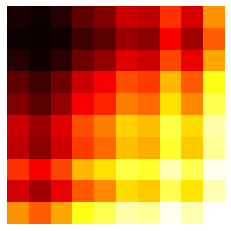

In [172]:
plt.imshow(sampe_gaf_block, cmap='hot', interpolation='nearest')
plt.axis('off');

In [173]:
pkl_file = f"2022-03-11-w{window_size:03}-Close.pkl"
gaf_dir = "nasdaq-daily-1K"
from_pkl = np.load(f"{gaf_dir}/{pkl_file}", allow_pickle=True)
from_pkl

array([[-0.94571498, -0.98633538, -0.9217975 , -0.74387177, -0.64401318,
        -0.42382443, -0.47630037, -0.12355463, -0.39409023,  0.16474984],
       [-0.98633538, -1.        , -0.97307034, -0.84381305, -0.76124898,
        -0.56725427, -0.61465358, -0.28535379, -0.54012206,  0.        ],
       [-0.9217975 , -0.97307034, -0.89373179, -0.69739008, -0.59127342,
        -0.36214482, -0.41627683, -0.05674497, -0.33158399,  0.23050836],
       [-0.74387177, -0.84381305, -0.69739008, -0.42404092, -0.29436419,
        -0.03671286, -0.09535477,  0.27353983, -0.00413527,  0.53663725],
       [-0.64401318, -0.76124898, -0.59127342, -0.29436419, -0.15900002,
         0.10221253,  0.04359876,  0.40427293,  0.13456769,  0.64845971],
       [-0.42382443, -0.56725427, -0.36214482, -0.03671286,  0.10221253,
         0.35644519,  0.30094329,  0.6274335 ,  0.38669605,  0.82354271],
       [-0.47630037, -0.61465358, -0.41627683, -0.09535477,  0.04359876,
         0.30094329,  0.24440194,  0.58060702

In [174]:
sampe_gaf_block == from_pkl

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

# Incorporated Version

In [ ]:
def get_gaf_embedding(gaf_dir, idx, data_cols, window_size):
    gaf = np.zeros((window_size**2, 4)) 
    start_date = df1K.index[idx] 
    print(start_date)
    for i, col in enumerate(data_cols):
        col_file = f"{start_date}-w{window_size:03}-{col}.pkl"
        # load pkl; reshape to 1x100 vector
        col_gaf = np.load(f"{gaf_dir}/{col_file}", allow_pickle=True)
        col_gaf = col_gaf.reshape(-1)
        gaf[:, i] = col_gaf  
    return gaf